In [2]:
####ESTE SCRIPT PREPARA UN ARCHIVO DE RSTUDIO PARA EL PLOTEO DE MAPAS
### ARCHIVOS: Artículo.R
import numpy as np
import os.path
import pandas as pd
from statistics import mean, mode
from datetime import datetime, timedelta
import random
import jupyterthemes
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import rayleigh
from scipy.stats import poisson
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy.stats import ttest_rel #tpareada
from scipy import stats

###########################################################
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
###########################################################
from tqdm import tqdm# barras de progreso
###########################################################

#Para no visualizar la salida de la intruccion to_datetime
from contextlib import redirect_stdout
import io

path = os.getcwd()
os.getcwd()

#dataframe = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\DatoLi.csv')
dataframe = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\Actualizada_filtrada_esp.csv')
dataframe['date_start_2'] = dataframe['date']
municipios = pd.read_excel('C:\\Users\\PC\\Desktop\\Narco\\entropía\\Municipios.xlsx')
poblacion = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\municipio-population2010-2030.csv')
poblacion_raw = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\municipio-population2010-2030.csv')
defunciones = pd.read_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\defunciones.csv')
# Creamos un flujo nulo para redirigir la salida
null_stream = io.StringIO()

with redirect_stdout(null_stream):
    dataframe['date_start_2'] = pd.to_datetime(dataframe['date_start_2'], format='%Y/%m/%d')
    dataframe['date'] = pd.to_datetime(dataframe['date'], format='%Y/%m/%d')
##############################################################################################################################
##############################################################################################################################
################ PARA ELEGIR SI MUERTES O EVENTOS SERÁN CALCULADOS ###########################################################
#PROPIEDAD = 'evento'
PROPIEDAD = 'best_est'
##############################################################################################################################
##############################################################################################################################
#############################################################################################################################

In [3]:
dataframe


,date,adm_1,adm_2,cart_a,cart_b,mue_a,mue_b,mue_civ,mue_desc,best_est,latitude,longitude,date_start_2
0,2004-01-23,Tamaulipas,Nuevo Laredo,Cártel del Golfo,Cártel de Sinaloa,0,0,0,3,3,27.484635,-99.522106,2004-01-23
1,2004-05-03,Sonora,Agua Prieta,Cártel de Juárez,Cártel de Sinaloa,0,0,0,4,4,31.330710,-109.548760,2004-05-03
2,2004-05-10,Tamaulipas,Matamoros,Cártel del Golfo,Cártel de Sinaloa,0,0,0,5,5,25.879720,-97.504170,2004-05-10
3,2004-08-15,Nuevo León,Montemorelos,Cártel del Golfo,Cártel de Sinaloa,0,0,0,1,1,25.189090,-99.828650,2004-08-15
4,2004-08-23,Chihuahua,Juárez,Cártel de Juárez,Cártel de Sinaloa,0,0,0,3,3,31.739444,-106.486944,2004-08-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12781,2022-12-30,Baja California,Tijuana,Cártel de Jalisco Nueva Generación,Cártel de Sinaloa,0,0,0,1,1,32.502700,-117.003710,2022-12-30
12782,2022-12-30,Baja California,Tijuana,Cártel de Jalisco Nueva Generación,Cártel de Sinaloa,0,0,0,2,2,32.502700,-117.003710,2022-12-30
12783,2022-12-30,Chihuahua,Juárez,Cártel de Juárez,Cártel de Sinaloa,0,0,0,1,1,31.739444,-106.486944,2022-12-30
12784,2022-12-31,Guanajuato,Irapuato,Cártel de Jalisco Nueva Generación,Cártel Santa Rosa de Lima,0,0,0,1,1,20.593898,-101.464856,2022-12-31


In [4]:
#columnas_inutiles = ['latitude', 'longitude', 'mue_a', 'mue_b', 'mue_civ']
columnas_inutiles = ['mue_a', 'mue_b', 'mue_civ']
############# COMPARACIONES ENTRE SEXENIOS, CALDERÓN, PEÑA Y OBRADOR (COMIENZO)
inicio1 = pd.Timestamp(year=2006, month=12, day=1)  # Inicio de diciembre de 2006
fin1 = pd.Timestamp(year=2012, month=11, day=30)    # Fin de noviembre de 2012
filtrocalderon = (dataframe['date_start_2'] >= inicio1) & (dataframe['date_start_2'] <= fin1)
datacalderon = dataframe[filtrocalderon].copy().reset_index(drop=True)
datacalderon = datacalderon.drop(columns=columnas_inutiles)
datacalderon['date'] = pd.to_datetime(datacalderon['date'])#extraemos mes##############################################
datacalderon['date'] = datacalderon['date'].dt.to_period('M')
datacalderon['evento'] = 1
datacalderon_total_mes = datacalderon.groupby(['date'])['best_est','evento'].sum().reset_index()

rangofecha = pd.period_range(start='2006-12', end='2012-11', freq='M')
datacalderon_total_mes = datacalderon_total_mes.set_index('date').reindex(rangofecha).reset_index()
datacalderon_total_mes.rename(columns={'index': 'date'}, inplace=True)

datacalderon_total_mes.fillna(0, inplace=True)
datacalderon_total_mes['date'] = datacalderon_total_mes['date'].dt.to_timestamp()
datacalderon_total_mes['date'] = pd.to_datetime(datacalderon_total_mes['date'], format='%Y/%m')
#datacalderon_total_mes['date'] = datacalderon_total_mes['date'].dt.strftime('%Y-%m')
#datacalderon_total_mes['date'] = datacalderon_total_mes['date'].dt.to_period('M')

#datacalderon_total_mes

C:\Users\PC\AppData\Local\Temp/ipykernel_7664/687034000.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  datacalderon_total_mes = datacalderon.groupby(['date'])['best_est','evento'].sum().reset_index()


,date,adm_1,adm_2,cart_a,cart_b,mue_desc,best_est,latitude,longitude,date_start_2,evento
0,2007-01,Sinaloa,Culiacán,Cártel del Golfo,Cártel de Sinaloa,1,1,24.70309,-107.352650,2007-01-02,1
1,2007-01,Sonora,Agua Prieta,Cártel del Golfo,Cártel de Sinaloa,0,0,31.21356,-109.427560,2007-01-04,1
2,2007-01,Baja California,Tijuana,Cártel de Sinaloa,Cártel de Tijuana,1,1,32.50223,-116.972120,2007-01-04,1
3,2007-01,Baja California,Tijuana,Cártel de Sinaloa,Cártel de Tijuana,1,1,32.50223,-116.972120,2007-01-05,1
4,2007-01,Guerrero,Acapulco de Juárez,Cártel del Golfo,Cártel de Sinaloa,1,1,16.92662,-99.744940,2007-01-05,1
...,...,...,...,...,...,...,...,...,...,...,...
2865,2012-11,Coahuila,Torreón,Los Zetas,Cártel de Sinaloa,4,4,25.54333,-103.417605,2012-11-03,1
2866,2012-11,Durango,Indé,Cártel de Sinaloa,Civiles,0,0,25.76777,-105.036310,2012-11-19,1
2867,2012-11,Sinaloa,Sinaloa,Cártel Beltrán Leyva,Cártel de Sinaloa,2,2,26.00083,-108.194440,2012-11-24,1
2868,2012-11,Chihuahua,Meoqui,Cártel de Juárez,Cártel de Sinaloa,5,5,28.33926,-105.527650,2012-11-24,1


In [3]:
############################################################################################################################
fechas_calderon = pd.date_range(start='2006-12-01', end='2012-11-01', freq='MS')
# Crear un DataFrame con las fechas
fechas_calderon_mes = fechas_calderon.strftime('%Y-%m')
vacio = pd.DataFrame({'date': fechas_calderon_mes})
################################## lISTA CARTELES SIN REPETIR ####################################################################
lista_carteles = {}
carteles = pd.DataFrame()
carteles = pd.concat([datacalderon['cart_a'], datacalderon['cart_b']])
lista_carteles = carteles.unique() #pd.DataFrame(carteles.unique())
lista_carteles_calderon = lista_carteles
################################## INICIA ALGORITMO, UNA COLUMNA POR CARTEL #######################################################
#'''
rangofecha = pd.period_range(start='2006-12', end='2012-11', freq='M')

for cartel in tqdm(lista_carteles):
    filtro = datacalderon['cart_a'].str.contains(f'{cartel}', case=False) | datacalderon['cart_b'].str.contains(f'{cartel}', case=False)
    datacalderon_mes = datacalderon[filtro]
    datacalderon_mes = datacalderon_mes.groupby(['date'])[PROPIEDAD].sum().reset_index()
    #AQUI FALTA RELLENAR LAS FECHAS QUE NO APARECEN
    datacalderon_mes = datacalderon_mes.set_index('date').reindex(rangofecha).reset_index()
    for k in range(72):
        vacio.loc[k, f'{cartel}'] = datacalderon_mes.loc[k, PROPIEDAD]
vacio.fillna(0, inplace=True)
vacio['date'] = pd.to_datetime(vacio['date'], format='%Y/%m')
#vacio['date'] = vacio['date'].dt.strftime('%Y-%m')
vacio_calderon = vacio
#'''
########################################################################################################################################            
sexenio_calderon = [2006, 2007, 2008, 2009, 2010, 2011, 2012]
############################################################################################################################
#vacio


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.19it/s]


In [4]:
lista_principales = ['Cártel de Sinaloa', 'Cártel del Golfo', 'Cártel de Juárez',  'Los Zetas', 'Cártel de Tijuana', 'Cártel de Jalisco Nueva Generación']
correlaciones = []

for año in sexenio_calderon:
    vacio_parcial = vacio[vacio['date'].dt.year == año].reset_index()
    datacalderon_total_mes_parcial = datacalderon_total_mes[datacalderon_total_mes['date'].dt.year == año].reset_index()
    for cartel in lista_principales:
        correlacion = datacalderon_total_mes_parcial[PROPIEDAD].corr(vacio_parcial[cartel])
        #correlaciones.append({f'corr_{cartel}': correlacion})
        correlaciones.append({'año': año, f'correlation_{cartel}': correlacion})


C:\Users\PC\anaconda3\envs\jeff\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\PC\anaconda3\envs\jeff\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [5]:
corr = pd.DataFrame(correlaciones)#AHORA HAY QUE LIMPIAR ESTA CHINGADERA POR COLUMNA SINO ES IMPOSIBLE
corr_sinaloa=pd.DataFrame(corr['correlation_Cártel de Sinaloa'].dropna())
corr_gulf=pd.DataFrame(corr['correlation_Cártel del Golfo'].dropna())
corr_juarez=pd.DataFrame(corr['correlation_Cártel de Juárez'].dropna())
corr_tijuana=pd.DataFrame(corr['correlation_Cártel de Tijuana'].dropna())
corr_zetas=pd.DataFrame(corr['correlation_Los Zetas'].dropna())
corr_cjng=pd.DataFrame(corr['correlation_Cártel de Jalisco Nueva Generación'].dropna())

#  Iterar sobre los índices de corr
for i in corr.index:
    for k in corr_sinaloa.index:
        if i == k:
            corr_sinaloa.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_gulf.index:
        if i == k:
            corr_gulf.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_juarez.index:
        if i == k:
            corr_juarez.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_tijuana.index:
        if i == k:
            corr_tijuana.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_zetas.index:
        if i == k:
            corr_zetas.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_cjng.index:
        if i == k:
            corr_cjng.loc[k, 'año'] = corr.loc[i, 'año']

corr_sinaloa['año'] = corr_sinaloa['año'].astype(int)
corr_gulf['año'] = corr_gulf['año'].astype(int)
corr_juarez['año'] = corr_juarez['año'].astype(int)
corr_tijuana['año'] = corr_tijuana['año'].astype(int)
corr_zetas['año'] = corr_zetas['año'].astype(int)
corr_cjng['año'] = corr_cjng['año'].astype(int)

corr_sinaloa = corr_sinaloa.reset_index(drop=True)
corr_gulf = corr_gulf.reset_index(drop=True)
corr_juarez = corr_juarez.reset_index(drop=True)
corr_tijuana = corr_tijuana.reset_index(drop=True)
corr_zetas = corr_zetas.reset_index(drop=True)
corr_cjng = corr_cjng.reset_index(drop=True)

lista_df = [corr_sinaloa.copy(), corr_gulf.copy(), corr_juarez.copy(), corr_tijuana.copy(), corr_zetas.copy(), corr_cjng.copy()]
raw = pd.DataFrame({'año': [2007, 2008, 2009, 2010, 2011, 2012]})

corr_sinaloa = pd.merge(raw, corr_sinaloa, on='año', how='left')
corr_sinaloa.fillna(0, inplace=True)
corr_gulf = pd.merge(raw, corr_gulf, on='año', how='left')
corr_gulf.fillna(0, inplace=True)
corr_juarez = pd.merge(raw, corr_juarez, on='año', how='left')
corr_juarez.fillna(0, inplace=True)
corr_tijuana = pd.merge(raw, corr_tijuana, on='año', how='left')
corr_tijuana.fillna(0, inplace=True)
corr_zetas = pd.merge(raw, corr_zetas, on='año', how='left')
corr_zetas.fillna(0, inplace=True)
corr_cjng = pd.merge(raw, corr_cjng, on='año', how='left')
corr_cjng.fillna(0, inplace=True)

corr_resultante = pd.concat([corr_sinaloa, corr_gulf, corr_juarez, corr_tijuana, corr_zetas, corr_cjng], axis=1)
corr_resultante = corr_resultante.drop('año', axis=1)

años = list(range(2007, 2013))

# Agregamos una nueva columna al DataFrame con los valores de los años repetidos
corr_resultante = corr_resultante.assign(año=años * (len(corr_resultante) // len(años)) + años[:len(corr_resultante) % len(años)])


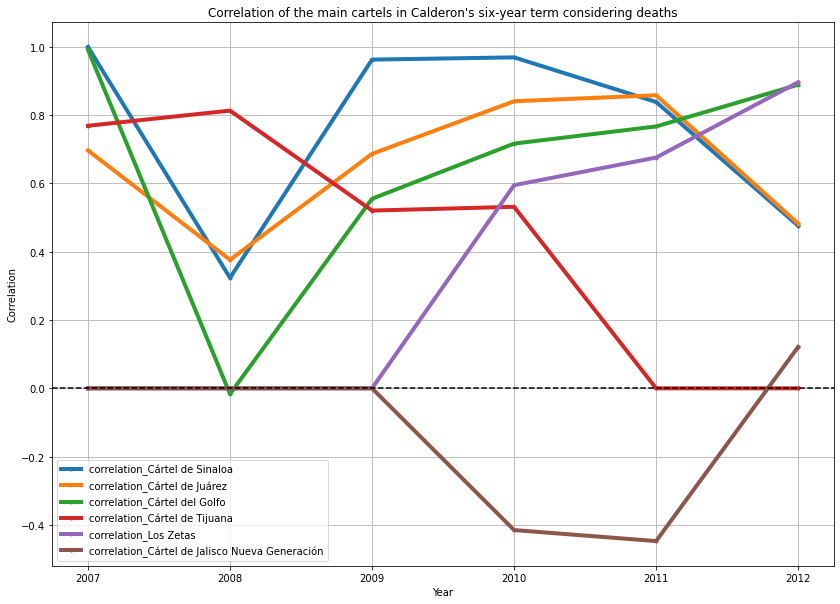

In [6]:
# Definir las columnas que deseas graficar
columnas_graficar = ['correlation_Cártel de Sinaloa', 'correlation_Cártel de Juárez', 'correlation_Cártel del Golfo', 'correlation_Cártel de Tijuana', 'correlation_Los Zetas', 'correlation_Cártel de Jalisco Nueva Generación']  # Reemplaza con los nombres reales de las columnas

plt.figure(figsize=(14, 10))

for columna in columnas_graficar:
    plt.plot(corr_resultante['año'], corr_resultante[columna], linewidth=4, marker='o', markersize=3)

plt.axhline(0, color='black', linestyle='--')
# Agregar etiquetas y título al gráfico
plt.xlabel('Year')
plt.ylabel('Correlation')
if PROPIEDAD == 'best_est':
    plt.title(f'Correlation of the main cartels in Calderon\'s six-year term considering deaths')
else:
    plt.title(f'Correlation of the main cartels in Calderon\'s six-year term considering events')

# Crear la leyenda manualmente y ajustar el tamaño de la fuente
plt.legend(columnas_graficar)

plt.grid(True)  # Agregar cuadrícula al gráfico

plt.savefig(f'C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Correlacion calderon {PROPIEDAD}.png', dpi=300, bbox_inches='tight', pad_inches=0.05)


plt.show()

In [7]:
##############################################################################################################################
# SEXENIO DE PEÑA
#columnas_inutiles = ['latitude', 'longitude', 'mue_a', 'mue_b', 'mue_civ']
columnas_inutiles = ['mue_a', 'mue_b', 'mue_civ']

inicio2 = pd.Timestamp(year=2012, month=12, day=1)  # Inicio de diciembre de 2006
fin2 = pd.Timestamp(year=2018, month=11, day=30)    # Fin de noviembre de 2012
filtronieto = (dataframe['date_start_2'] >= inicio2) & (dataframe['date_start_2'] <= fin2)
datanieto = dataframe[filtronieto].copy().reset_index(drop=True)
datanieto = datanieto.drop(columns=columnas_inutiles)
datanieto['date'] = pd.to_datetime(datanieto['date'])#extraemos mes##############################################
datanieto['date'] = datanieto['date'].dt.to_period('M')
datanieto['evento'] = 1
datanieto_total_mes = datanieto.groupby(['date'])['best_est','evento'].sum().reset_index()

rangofecha = pd.period_range(start='2012-12', end='2018-11', freq='M')
datanieto_total_mes = datanieto_total_mes.set_index('date').reindex(rangofecha).reset_index()
datanieto_total_mes.rename(columns={'index': 'date'}, inplace=True)

datanieto_total_mes.fillna(0, inplace=True)
datanieto_total_mes['date'] = datanieto_total_mes['date'].dt.to_timestamp()
datanieto_total_mes['date'] = pd.to_datetime(datanieto_total_mes['date'], format='%Y/%m')
#datanieto_total_mes

C:\Users\PC\AppData\Local\Temp/ipykernel_17780/833845685.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  datanieto_total_mes = datanieto.groupby(['date'])['best_est','evento'].sum().reset_index()


In [8]:
fechas_nieto = pd.date_range(start='2012-12-01', end='2018-11-01', freq='MS')
# Crear un DataFrame con las fechas
fechas_nieto_mes = fechas_nieto.strftime('%Y-%m')
vacio = pd.DataFrame({'date': fechas_nieto_mes})
################################## lISTA CARTELES SIN REPETIR ####################################################################
lista_carteles = {}
carteles = pd.DataFrame()
carteles = pd.concat([datanieto['cart_a'], datanieto['cart_b']])
lista_carteles = carteles.unique() #pd.DataFrame(carteles.unique())
lista_carteles_nieto = lista_carteles
################################## INICIA ALGORITMO, UNA COLUMNA POR CARTEL #######################################################
#'''
rangofecha = pd.period_range(start='2012-12', end='2018-11', freq='M')

for cartel in tqdm(lista_carteles):
    filtro = datanieto['cart_a'].str.contains(f'{cartel}', case=False) | datanieto['cart_b'].str.contains(f'{cartel}', case=False)
    datanieto_mes = datanieto[filtro]
    datanieto_mes = datanieto_mes.groupby(['date'])[PROPIEDAD].sum().reset_index()
    #AQUI FALTA RELLENAR LAS FECHAS QUE NO APARECEN
    datanieto_mes = datanieto_mes.set_index('date').reindex(rangofecha).reset_index()
    for k in range(72):
        vacio.loc[k, f'{cartel}'] = datanieto_mes.loc[k, PROPIEDAD]
vacio.fillna(0, inplace=True)
vacio['date'] = pd.to_datetime(vacio['date'], format='%Y/%m')

vacio_nieto  = vacio

#'''
########################################################################################################################################            
sexenio_nieto = [2012, 2013, 2014, 2015, 2016, 2017, 2018]
############################################################################################################################
#vacio

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 144.41it/s]


In [9]:
lista_principales = ['Cártel de Sinaloa', 'Cártel del Golfo', 'Cártel de Juárez',  'Los Zetas', 'Los Caballeros Templarios', 'Cártel de Jalisco Nueva Generación']
correlaciones = []

for año in sexenio_nieto:
    vacio_parcial = vacio[vacio['date'].dt.year == año].reset_index()
    datanieto_total_mes_parcial = datanieto_total_mes[datanieto_total_mes['date'].dt.year == año].reset_index()
    for cartel in lista_principales:
        correlacion = datanieto_total_mes_parcial[PROPIEDAD].corr(vacio_parcial[cartel])
        correlaciones.append({'año': año, f'correlation_{cartel}': correlacion})

C:\Users\PC\anaconda3\envs\jeff\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\PC\anaconda3\envs\jeff\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [10]:
corr = pd.DataFrame(correlaciones)#AHORA HAY QUE LIMPIAR ESTA CHINGADERA POR COLUMNA SINO ES IMPOSIBLE
corr_sinaloa=pd.DataFrame(corr['correlation_Cártel de Sinaloa'].dropna())
corr_gulf=pd.DataFrame(corr['correlation_Cártel del Golfo'].dropna())
corr_juarez=pd.DataFrame(corr['correlation_Cártel de Juárez'].dropna())
corr_lct=pd.DataFrame(corr['correlation_Los Caballeros Templarios'].dropna())
corr_zetas=pd.DataFrame(corr['correlation_Los Zetas'].dropna())
corr_cjng=pd.DataFrame(corr['correlation_Cártel de Jalisco Nueva Generación'].dropna())

#  Iterar sobre los índices de corr
for i in corr.index:
    for k in corr_sinaloa.index:
        if i == k:
            corr_sinaloa.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_gulf.index:
        if i == k:
            corr_gulf.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_juarez.index:
        if i == k:
            corr_juarez.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_lct.index:
        if i == k:
            corr_lct.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_zetas.index:
        if i == k:
            corr_zetas.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_cjng.index:
        if i == k:
            corr_cjng.loc[k, 'año'] = corr.loc[i, 'año']

corr_sinaloa['año'] = corr_sinaloa['año'].astype(int)
corr_gulf['año'] = corr_gulf['año'].astype(int)
corr_juarez['año'] = corr_juarez['año'].astype(int)
corr_lct['año'] = corr_lct['año'].astype(int)
corr_zetas['año'] = corr_zetas['año'].astype(int)
corr_cjng['año'] = corr_cjng['año'].astype(int)

corr_sinaloa = corr_sinaloa.reset_index(drop=True)
corr_gulf = corr_gulf.reset_index(drop=True)
corr_juarez = corr_juarez.reset_index(drop=True)
corr_lct = corr_lct.reset_index(drop=True)
corr_zetas = corr_zetas.reset_index(drop=True)
corr_cjng = corr_cjng.reset_index(drop=True)

lista_df = [corr_sinaloa.copy(), corr_gulf.copy(), corr_juarez.copy(), corr_lct.copy(), corr_zetas.copy(), corr_cjng.copy()]
raw = pd.DataFrame({'año': [2013, 2014, 2015, 2016, 2017, 2018]})

corr_sinaloa = pd.merge(raw, corr_sinaloa, on='año', how='left')
corr_sinaloa.fillna(0, inplace=True)
corr_gulf = pd.merge(raw, corr_gulf, on='año', how='left')
corr_gulf.fillna(0, inplace=True)
corr_juarez = pd.merge(raw, corr_juarez, on='año', how='left')
corr_juarez.fillna(0, inplace=True)
corr_lct = pd.merge(raw, corr_lct, on='año', how='left')
corr_lct.fillna(0, inplace=True)
corr_zetas = pd.merge(raw, corr_zetas, on='año', how='left')
corr_zetas.fillna(0, inplace=True)
corr_cjng = pd.merge(raw, corr_cjng, on='año', how='left')
corr_cjng.fillna(0, inplace=True)

corr_resultante = pd.concat([corr_sinaloa, corr_gulf, corr_juarez, corr_lct, corr_zetas, corr_cjng], axis=1)
corr_resultante = corr_resultante.drop('año', axis=1)

años = list(range(2013, 2019))

# Agregamos una nueva columna al DataFrame con los valores de los años repetidos
corr_resultante = corr_resultante.assign(año=años * (len(corr_resultante) // len(años)) + años[:len(corr_resultante) % len(años)])
corr_resultante

,correlation_Cártel de Sinaloa,correlation_Cártel del Golfo,correlation_Cártel de Juárez,correlation_Los Caballeros Templarios,correlation_Los Zetas,correlation_Cártel de Jalisco Nueva Generación,año
0,0.668069,0.714482,0.403823,0.118664,0.826650,0.118973,2013
1,0.746429,0.381515,0.520639,0.692140,-0.153062,0.425998,2014
2,0.828253,0.084980,0.405952,0.195960,0.556424,0.625758,2015
3,0.359365,0.065210,0.123297,0.167263,0.737629,0.244215,2016
4,0.691886,0.505605,0.348579,0.000000,0.530537,0.574041,2017
5,0.769444,0.183118,0.157335,0.000000,0.640653,0.928981,2018


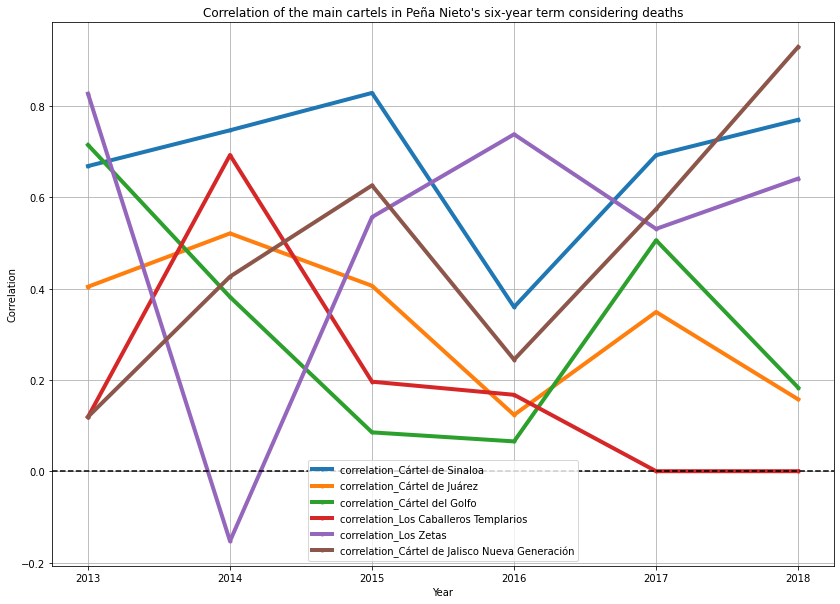

In [11]:
# Definir las columnas que deseas graficar
columnas_graficar = ['correlation_Cártel de Sinaloa', 'correlation_Cártel de Juárez', 'correlation_Cártel del Golfo', 'correlation_Los Caballeros Templarios', 'correlation_Los Zetas', 'correlation_Cártel de Jalisco Nueva Generación']  # Reemplaza con los nombres reales de las columnas

plt.figure(figsize=(14, 10))

for columna in columnas_graficar:
    plt.plot(corr_resultante['año'], corr_resultante[columna], linewidth=4, marker='o', markersize=3)

plt.axhline(0, color='black', linestyle='--')
# Agregar etiquetas y título al gráfico
plt.xlabel('Year')
plt.ylabel('Correlation')
if PROPIEDAD == 'best_est':
    plt.title(f'Correlation of the main cartels in Peña Nieto\'s six-year term considering deaths')
else:
    plt.title(f'Correlation of the main cartels in Peña Nieto\'s six-year term considering events')

# Crear la leyenda manualmente y ajustar el tamaño de la fuente
plt.legend(columnas_graficar)

plt.grid(True)  # Agregar cuadrícula al gráfico

plt.savefig(f'C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Correlacion nieto {PROPIEDAD}.png', dpi=300, bbox_inches='tight', pad_inches=0.05)


plt.show()

In [12]:
##############################################################################################################################
# SEXENIO DE OBRADOR
#columnas_inutiles = ['latitude', 'longitude', 'mue_a', 'mue_b', 'mue_civ']
columnas_inutiles = ['mue_a', 'mue_b', 'mue_civ']

inicio3 = pd.Timestamp(year=2018, month=12, day=1)  # Inicio de diciembre de 2006
fin3 = pd.Timestamp(year=2022, month=12, day=30)    # Fin de noviembre de 2012
filtroobrador = (dataframe['date_start_2'] >= inicio3) & (dataframe['date_start_2'] <= fin3)
dataobrador = dataframe[filtroobrador].copy().reset_index(drop=True)
dataobrador = dataobrador.drop(columns=columnas_inutiles)
dataobrador['date'] = pd.to_datetime(dataobrador['date'])#extraemos mes##############################################
dataobrador['date'] = dataobrador['date'].dt.to_period('M')
dataobrador['evento'] = 1
dataobrador_total_mes = dataobrador.groupby(['date'])['best_est','evento'].sum().reset_index()

rangofecha = pd.period_range(start='2018-12', end='2022-12', freq='M')
dataobrador_total_mes = dataobrador_total_mes.set_index('date').reindex(rangofecha).reset_index()
dataobrador_total_mes.rename(columns={'index': 'date'}, inplace=True)

dataobrador_total_mes.fillna(0, inplace=True)
dataobrador_total_mes['date'] = dataobrador_total_mes['date'].dt.to_timestamp()
dataobrador_total_mes['date'] = pd.to_datetime(dataobrador_total_mes['date'], format='%Y/%m')
#datanieto_total_mes

C:\Users\PC\AppData\Local\Temp/ipykernel_17780/1182647819.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dataobrador_total_mes = dataobrador.groupby(['date'])['best_est','evento'].sum().reset_index()


In [13]:
fechas_obrador = pd.date_range(start='2018-12-01', end='2022-12-01', freq='MS')
# Crear un DataFrame con las fechas
fechas_obrador_mes = fechas_obrador.strftime('%Y-%m')
vacio = pd.DataFrame({'date': fechas_obrador_mes})
################################## lISTA CARTELES SIN REPETIR ####################################################################
lista_carteles = {}
carteles = pd.DataFrame()
carteles = pd.concat([dataobrador['cart_a'], dataobrador['cart_b']])
lista_carteles = carteles.unique() #pd.DataFrame(carteles.unique())
lista_carteles_obrador = lista_carteles
################################## INICIA ALGORITMO, UNA COLUMNA POR CARTEL #######################################################
#'''
rangofecha = pd.period_range(start='2018-12', end='2022-12', freq='M')

for cartel in tqdm(lista_carteles):
    filtro = dataobrador['cart_a'].str.contains(f'{cartel}', case=False) | dataobrador['cart_b'].str.contains(f'{cartel}', case=False)
    dataobrador_mes = dataobrador[filtro]
    dataobrador_mes = dataobrador_mes.groupby(['date'])[PROPIEDAD].sum().reset_index()
    #AQUI FALTA RELLENAR LAS FECHAS QUE NO APARECEN
    dataobrador_mes = dataobrador_mes.set_index('date').reindex(rangofecha).reset_index()
    for k in range(49):
        vacio.loc[k, f'{cartel}'] = dataobrador_mes.loc[k, PROPIEDAD]
vacio.fillna(0, inplace=True)
vacio['date'] = pd.to_datetime(vacio['date'], format='%Y/%m')

vacio_obrador = vacio

#'''
########################################################################################################################################            
sexenio_obrador = [2019, 2020, 2021, 2022]
############################################################################################################################
#vacio

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 94.06it/s]


In [14]:
lista_principales=[]
lista_principales = ['Cártel de Jalisco Nueva Generación', 'Cártel de Sinaloa', 'Cártel Santa Rosa de Lima', 'Cártel de Juárez', 'Cártel de Sinaloa - Los Chapitos', 'Los Zetas']
correlaciones = []

for año in sexenio_obrador:
    vacio_parcial = vacio[vacio['date'].dt.year == año].reset_index()
    dataobrador_total_mes_parcial = dataobrador_total_mes[dataobrador_total_mes['date'].dt.year == año].reset_index()
    for cartel in lista_principales:
        correlacion = dataobrador_total_mes_parcial[PROPIEDAD].corr(vacio_parcial[cartel])
        correlaciones.append({'año': año, f'correlation_{cartel}': correlacion})

In [15]:
corr = pd.DataFrame(correlaciones)#AHORA HAY QUE LIMPIAR ESTA CHINGADERA POR COLUMNA SINO ES IMPOSIBLE
corr_sinaloa=pd.DataFrame(corr['correlation_Cártel de Sinaloa'].dropna())
corr_srdl=pd.DataFrame(corr['correlation_Cártel Santa Rosa de Lima'].dropna())
corr_juarez=pd.DataFrame(corr['correlation_Cártel de Juárez'].dropna())
corr_chapitos=pd.DataFrame(corr['correlation_Cártel de Sinaloa - Los Chapitos'].dropna())
corr_zetas=pd.DataFrame(corr['correlation_Los Zetas'].dropna())
corr_cjng=pd.DataFrame(corr['correlation_Cártel de Jalisco Nueva Generación'].dropna())

#  Iterar sobre los índices de corr
for i in corr.index:
    for k in corr_sinaloa.index:
        if i == k:
            corr_sinaloa.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_srdl.index:
        if i == k:
            corr_srdl.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_juarez.index:
        if i == k:
            corr_juarez.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_chapitos.index:
        if i == k:
            corr_chapitos.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_zetas.index:
        if i == k:
            corr_zetas.loc[k, 'año'] = corr.loc[i, 'año']
    for k in corr_cjng.index:
        if i == k:
            corr_cjng.loc[k, 'año'] = corr.loc[i, 'año']

corr_sinaloa['año'] = corr_sinaloa['año'].astype(int)
corr_srdl['año'] = corr_srdl['año'].astype(int)
corr_juarez['año'] = corr_juarez['año'].astype(int)
corr_chapitos['año'] = corr_chapitos['año'].astype(int)
corr_zetas['año'] = corr_zetas['año'].astype(int)
corr_cjng['año'] = corr_cjng['año'].astype(int)

corr_sinaloa = corr_sinaloa.reset_index(drop=True)
corr_srdl = corr_srdl.reset_index(drop=True)
corr_juarez = corr_juarez.reset_index(drop=True)
corr_chapitos = corr_chapitos.reset_index(drop=True)
corr_zetas = corr_zetas.reset_index(drop=True)
corr_cjng = corr_cjng.reset_index(drop=True)

lista_df = [corr_sinaloa.copy(), corr_srdl.copy(), corr_juarez.copy(), corr_chapitos.copy(), corr_zetas.copy(), corr_cjng.copy()]
raw = pd.DataFrame({'año': [2019, 2020, 2021, 2022]})

corr_sinaloa = pd.merge(raw, corr_sinaloa, on='año', how='left')
corr_sinaloa.fillna(0, inplace=True)
corr_srdl = pd.merge(raw, corr_srdl, on='año', how='left')
corr_srdl.fillna(0, inplace=True)
corr_juarez = pd.merge(raw, corr_juarez, on='año', how='left')
corr_juarez.fillna(0, inplace=True)
corr_chapitos = pd.merge(raw, corr_chapitos, on='año', how='left')
corr_chapitos.fillna(0, inplace=True)
corr_zetas = pd.merge(raw, corr_zetas, on='año', how='left')
corr_zetas.fillna(0, inplace=True)
corr_cjng = pd.merge(raw, corr_cjng, on='año', how='left')
corr_cjng.fillna(0, inplace=True)

corr_resultante = pd.concat([corr_sinaloa, corr_srdl, corr_juarez, corr_chapitos, corr_zetas, corr_cjng], axis=1)
corr_resultante = corr_resultante.drop('año', axis=1)

años = list(range(2019, 2023))

# Agregamos una nueva columna al DataFrame con los valores de los años repetidos
corr_resultante = corr_resultante.assign(año=años * (len(corr_resultante) // len(años)) + años[:len(corr_resultante) % len(años)])
corr_resultante

,correlation_Cártel de Sinaloa,correlation_Cártel Santa Rosa de Lima,correlation_Cártel de Juárez,correlation_Cártel de Sinaloa - Los Chapitos,correlation_Los Zetas,correlation_Cártel de Jalisco Nueva Generación,año
0,0.499828,0.247239,0.615695,0.000000,0.419874,0.886743,2019
1,0.811815,0.723080,0.801300,-0.027614,-0.326994,0.962371,2020
2,0.522166,0.729653,0.471229,-0.012841,-0.125544,0.906616,2021
3,0.721453,0.741611,0.645854,0.309278,-0.001803,0.848093,2022


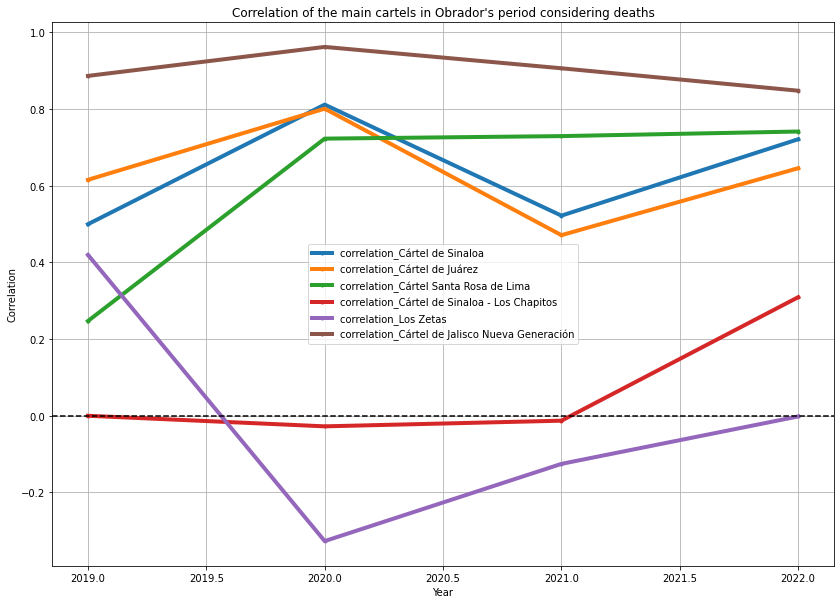

In [16]:
# Definir las columnas que deseas graficar
columnas_graficar = ['correlation_Cártel de Sinaloa', 'correlation_Cártel de Juárez', 'correlation_Cártel Santa Rosa de Lima', 'correlation_Cártel de Sinaloa - Los Chapitos', 'correlation_Los Zetas', 'correlation_Cártel de Jalisco Nueva Generación']  # Reemplaza con los nombres reales de las columnas

plt.figure(figsize=(14, 10))

for columna in columnas_graficar:
    plt.plot(corr_resultante['año'], corr_resultante[columna], linewidth=4, marker='o', markersize=3)

plt.axhline(0, color='black', linestyle='--')
# Agregar etiquetas y título al gráfico
plt.xlabel('Year')
plt.ylabel('Correlation')
if PROPIEDAD == 'best_est':
    plt.title(f'Correlation of the main cartels in Obrador\'s period considering deaths')
else:
    plt.title(f'Correlation of the main cartels in Obrador\'s period considering events')

# Crear la leyenda manualmente y ajustar el tamaño de la fuente
plt.legend(columnas_graficar)

plt.grid(True)  # Agregar cuadrícula al gráfico

plt.savefig(f'C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Correlacion obrador {PROPIEDAD}.png', dpi=300, bbox_inches='tight', pad_inches=0.05)


plt.show()

In [17]:
correlacion_calderon=[]
for cartel in lista_carteles_calderon:
    correlacion_calderon_aux = datacalderon_total_mes[PROPIEDAD].corr(vacio_calderon[f'{cartel}'])
    #correlacion_calderon.append({'cartel': cartel, f'correlacion_{cartel}': correlacion_calderon_aux})
    correlacion_calderon.append({'Cartel': cartel, 'Correlation': correlacion_calderon_aux})
df_calderon = pd.DataFrame(correlacion_calderon, columns=['Cartel', 'Correlation']).sort_values(by='Correlation', ascending=False).reset_index(drop=True)
df_calderon['Correlation'] = df_calderon['Correlation'].round(3)

In [18]:
df_calderon.shape

(20, 2)

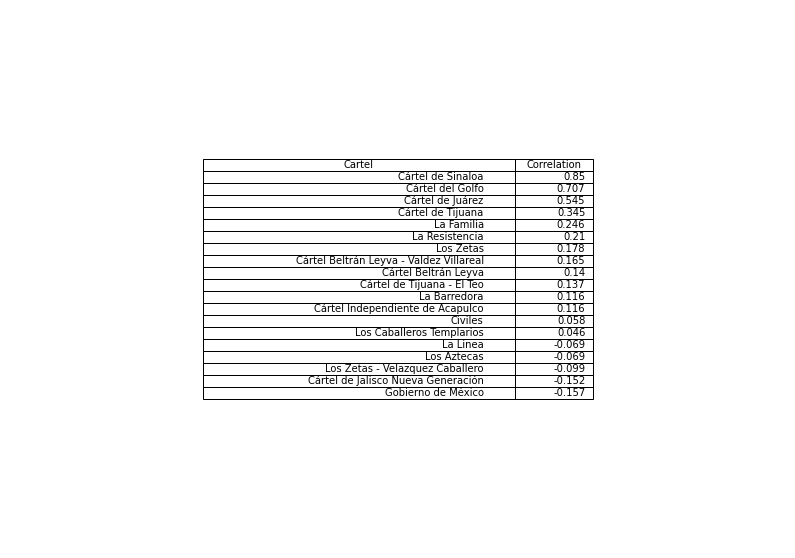

In [19]:
# Filtrar las filas que NO contienen una coma
df_calderon = df_calderon[~df_calderon['Cartel'].str.contains(",")]

column_widths = [0.4, 0.1] 
plt.figure(figsize=(14, 10))  
# Crear una tabla de matplotlib a partir del DataFrame
tabla = plt.table(cellText=df_calderon.values, colLabels=df_calderon.columns, colWidths=column_widths, loc='center')
#plt.title('Correlaciones de todos los cárteles operativos en el sexenio de Obrador')

# Ocultar los ejes
ax = plt.gca()
ax.axis('off')

plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Correlacion Calderon Todos.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
df_calderon.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Tabla_calderon.csv', index=False)


In [20]:
correlacion_nieto=[]
for cartel in lista_carteles_nieto:
    correlacion_nieto_aux = datanieto_total_mes[PROPIEDAD].corr(vacio_nieto[f'{cartel}'])
    #correlacion_calderon.append({'cartel': cartel, f'correlacion_{cartel}': correlacion_calderon_aux})
    correlacion_nieto.append({'Cartel': cartel, 'Correlation': correlacion_nieto_aux})
df_nieto = pd.DataFrame(correlacion_nieto, columns=['Cartel', 'Correlation']).sort_values(by='Correlation', ascending=False).reset_index(drop=True)
df_nieto['Correlation'] = df_nieto['Correlation'].round(3)

In [21]:
df_nieto.shape

(39, 2)

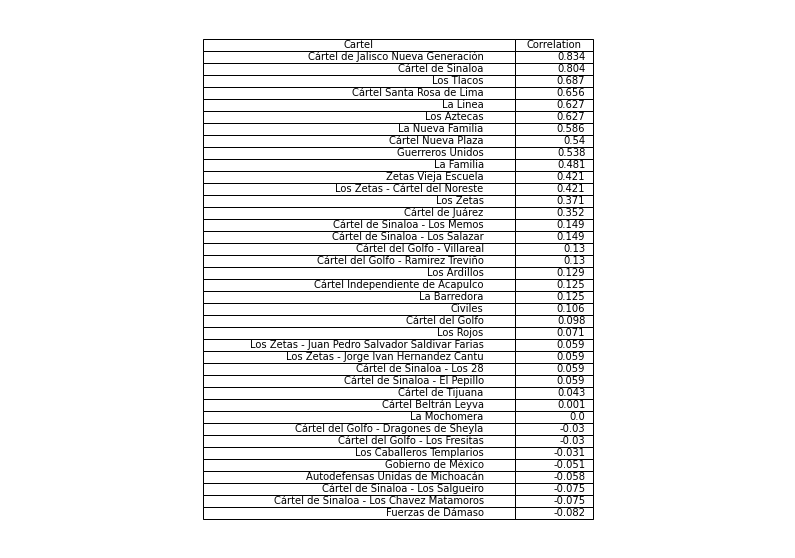

In [22]:
# Filtrar las filas que NO contienen una coma
df_nieto = df_nieto[~df_nieto['Cartel'].str.contains(",")]


column_widths = [0.4, 0.1] 
plt.figure(figsize=(14, 10))  
# Crear una tabla de matplotlib a partir del DataFrame
tabla = plt.table(cellText=df_nieto.values, colLabels=df_nieto.columns, colWidths=column_widths, loc='center')
#plt.title('Correlaciones de todos los cárteles operativos en el sexenio de Obrador')

# Ocultar los ejes
ax = plt.gca()
ax.axis('off')

plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Correlacion Nieto Todos.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
df_nieto.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Tabla_nieto.csv', index=False)


In [23]:
correlacion_obrador=[]
for cartel in lista_carteles_obrador:
    correlacion_obrador_aux = dataobrador_total_mes[PROPIEDAD].corr(vacio_obrador[f'{cartel}'])
    #correlacion_calderon.append({'cartel': cartel, f'correlacion_{cartel}': correlacion_calderon_aux})
    correlacion_obrador.append({'Cartel': cartel, 'Correlation': correlacion_obrador_aux})
df_obrador = pd.DataFrame(correlacion_obrador, columns=['Cartel', 'Correlation']).sort_values(by='Correlation', ascending=False).reset_index(drop=True)
df_obrador['Correlation'] = df_obrador['Correlation'].round(3)

In [24]:
df_obrador.shape

(38, 2)

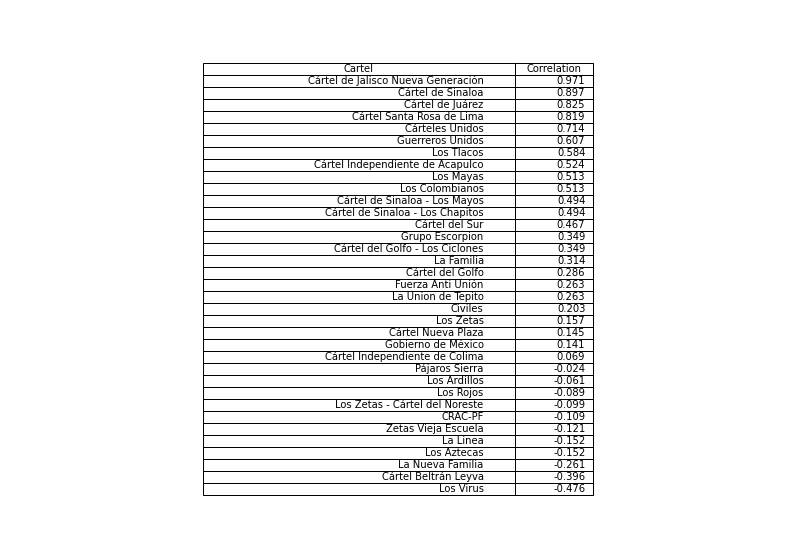

In [25]:
# Filtrar las filas que NO contienen una coma
df_obrador = df_obrador[~df_obrador['Cartel'].str.contains(",")]



column_widths = [0.4, 0.1] 
plt.figure(figsize=(14, 10))  
# Crear una tabla de matplotlib a partir del DataFrame
tabla = plt.table(cellText=df_obrador.values, colLabels=df_obrador.columns, colWidths=column_widths, loc='center')
#plt.title('Correlaciones de todos los cárteles operativos en el sexenio de Obrador')

# Ocultar los ejes
ax = plt.gca()
ax.axis('off')

plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Correlacion Obrador Todos.png', dpi=300, bbox_inches='tight', pad_inches=0.05)
df_obrador.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Tabla_obrador.csv', index=False)


In [26]:
###############################################################################################################################
###############################################################################################################################
######## PARA EL R DE ARTÍCULO3.R
dataframe_ev = dataframe
dataframe_ev['evento'] = 1
df_municipios = dataframe_ev[['adm_1', 'adm_2', 'best_est', 'evento']].groupby(['adm_1', 'adm_2']).sum().reset_index()
# Renombramos las columnas para que coincidan con los nombres deseados
# Guardamos las coordenadas de cada municipio
coordenadas = dataframe_ev[['adm_1', 'adm_2', 'latitude', 'longitude']].drop_duplicates(subset=['adm_1', 'adm_2'])
# Unimos las coordenadas con el DataFrame de municipios
df_municipios = pd.merge(df_municipios, coordenadas, on=['adm_1', 'adm_2'], how='left')
# Ahora, si quieres agrupar por nombre de municipio independientemente del estado, simplemente agrupa por 'Municipio'
df_municipios.columns = ['Estado', 'Municipio', 'Muertes', 'Eventos', 'Latitud', 'Longitud']
# Si deseas mantener la información del estado, puedes usar groupby con las dos columnas
#df_municipios = df_municipios.groupby(['Municipio', 'Estado']).sum().reset_index()
df_municipios['Estado'] = df_municipios['Estado'].str.replace('Coahuila', 'Coahuila de Zaragoza')
df_municipios['Estado'] = df_municipios['Estado'].str.replace('Michoacán', 'Michoacán de Ocampo')
df_municipios['Estado'] = df_municipios['Estado'].str.replace('Veracruz', 'Veracruz de Ignacio de la Llave')
df_municipios['Eventos_log'] = df_municipios['Eventos'].apply(np.log)
df_municipios['Muertes_log'] = df_municipios['Muertes'].apply(np.log)


#df_municipios.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\mapa_municipios_tot_definitivo.csv', index=False)

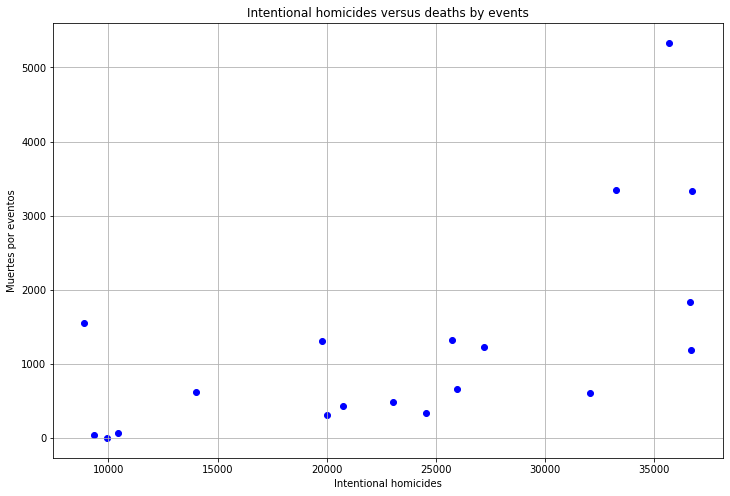

In [27]:
#Sacamos el DF anual de muertes
dataframe_año_muertes = dataframe
dataframe_año_muertes['year'] = dataframe['date'].dt.year
dataframe_año_muertes = dataframe_año_muertes.groupby(['year'])['best_est'].sum().reset_index()
#filtramos el df de defunciones para que empiece en el 2004
defunciones_filtrado = defunciones.loc[defunciones['Year'] >= 2004].reset_index(drop=True)

scatter_concatenado = pd.concat([defunciones_filtrado['Deaths'], dataframe_año_muertes['best_est']], axis=1)

# Crear el scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(scatter_concatenado['Deaths'], scatter_concatenado['best_est'], color='blue')
plt.xlabel('Intentional homicides')
plt.ylabel('Muertes por eventos')
plt.title('Intentional homicides versus deaths by events')
plt.grid(True)
plt.savefig('C:\\Users\\PC\\Desktop\\Narco\\entropía\\articulo\\Ingles\\Eventos Dolosos Total.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

plt.show()

In [28]:
################ SEXENIO DE CALDERON ################
# Agrupar por las columnas 'cart_a' y 'cart_b' y contar el número de eventos
parejas_frecuentes_calderon = datacalderon.groupby(['cart_a', 'cart_b']).size().reset_index(name='frecuencia')

# Ordenar por frecuencia de forma descendente
parejas_frecuentes_calderon = parejas_frecuentes_calderon.sort_values(by='frecuencia', ascending=False)

# Obtener las 10 parejas más frecuentes
top_10_parejas = parejas_frecuentes_calderon.head(10).reset_index(drop=True)
parejas_mas_frecuentes = top_10_parejas[['cart_a', 'cart_b']]
cadena_a_eliminar = "Cártel del Golfo, La Familia, Cártel de Sinaloa"
parejas_mas_frecuentes = parejas_mas_frecuentes[~parejas_mas_frecuentes['cart_a'].str.contains(cadena_a_eliminar)].reset_index(drop=True)

parejas_lista = [tuple(x) for x in parejas_mas_frecuentes.values]

# Filtrar las filas de la base de datos original que contienen alguna de las parejas más frecuentes
datacalderon_filtrado_mapa = datacalderon[datacalderon.apply(lambda row: (row['cart_a'], row['cart_b']) in parejas_lista, axis=1)]
# Fusionar los textos de las dos columnas con un guion entre ellos
datacalderon_filtrado_mapa['Parejas'] = datacalderon_filtrado_mapa['cart_a'] + ' - ' + datacalderon_filtrado_mapa['cart_b']
datacalderon_mapa = datacalderon_filtrado_mapa.groupby(['latitude', 'longitude', 'Parejas'])['evento'].sum().reset_index()
#datacalderon_mapa['Parejas'] = datacalderon_mapa['Parejas'].str.replace('Beltrán Leyva Cartel', 'Beltrán L.C.')
datacalderon_mapa['Parejas'] = datacalderon_mapa['Parejas'].str.replace(' Valdez Villareal', ' Valdez')
datacalderon_mapa['Parejas'] = datacalderon_mapa['Parejas'].str.replace('Cartel Independiente de Acapulco', 'C. Indep. Acapulco')
#datacalderon_mapa['Parejas'] = datacalderon_mapa['Parejas'].str.replace('Tijuana Cartel', 'Tijuana C.')

datacalderon_mapa.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\datacalderon_mapa.csv', index=False)
datacalderon_mapa

C:\Users\PC\AppData\Local\Temp/ipykernel_17780/3432685447.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datacalderon_filtrado_mapa['Parejas'] = datacalderon_filtrado_mapa['cart_a'] + ' - ' + datacalderon_filtrado_mapa['cart_b']


,latitude,longitude,Parejas,evento
0,14.64138,-92.22252,Cártel del Golfo - Cártel de Sinaloa,5
1,14.75148,-92.20712,Cártel del Golfo - Cártel de Sinaloa,2
2,14.90696,-92.26185,Cártel del Golfo - Cártel de Sinaloa,1
3,14.94755,-92.30211,Cártel del Golfo - Cártel de Sinaloa,8
4,15.33333,-92.63333,Cártel del Golfo - Cártel de Sinaloa,2
...,...,...,...,...
545,32.50513,-115.14771,Cártel de Sinaloa - Cártel de Tijuana,11
546,32.56717,-116.62509,Cártel de Sinaloa - Cártel de Tijuana,2
547,32.56717,-116.62509,Cártel de Tijuana - Cártel de Tijuana - El Teo,2
548,32.62781,-115.45446,Cártel de Sinaloa - Cártel de Tijuana,1


In [29]:
################ SEXENIO DE PEÑA ################
# Agrupar por las columnas 'cart_a' y 'cart_b' y contar el número de eventos
parejas_frecuentes_nieto = datanieto.groupby(['cart_a', 'cart_b']).size().reset_index(name='frecuencia')

# Ordenar por frecuencia de forma descendente
parejas_frecuentes_nieto = parejas_frecuentes_nieto.sort_values(by='frecuencia', ascending=False)

# Obtener las 10 parejas más frecuentes
top_10_parejas = parejas_frecuentes_nieto.head(10).reset_index(drop=True)
parejas_mas_frecuentes = top_10_parejas[['cart_a', 'cart_b']]
#cadena_a_eliminar = "Gulf Cartel, La Familia, Sinaloa Cartel"
#parejas_mas_frecuentes = parejas_mas_frecuentes[~parejas_mas_frecuentes['cart_a'].str.contains(cadena_a_eliminar)].reset_index(drop=True)

parejas_lista = [tuple(x) for x in parejas_mas_frecuentes.values]

# Filtrar las filas de la base de datos original que contienen alguna de las parejas más frecuentes
datanieto_filtrado_mapa = datanieto[datanieto.apply(lambda row: (row['cart_a'], row['cart_b']) in parejas_lista, axis=1)]
# Fusionar los textos de las dos columnas con un guion entre ellos
datanieto_filtrado_mapa['Parejas'] = datanieto_filtrado_mapa['cart_a'] + ' - ' + datanieto_filtrado_mapa['cart_b']
datanieto_mapa = datanieto_filtrado_mapa.groupby(['latitude', 'longitude', 'Parejas'])['evento'].sum().reset_index()
datanieto_mapa['Parejas'] = datanieto_mapa['Parejas'].str.replace('Cártel de Jalisco Nueva Generación', 'CJNG')
#datacalderon_mapa['Parejas'] = datacalderon_mapa['Parejas'].str.replace(' Valdez Villareal faction', ' Valdez')
#datacalderon_mapa['Parejas'] = datacalderon_mapa['Parejas'].str.replace('Cartel Independiente de Acapulco', 'C. Indep. Acapulco')

datanieto_mapa.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\datanieto_mapa.csv', index=False)
datanieto_mapa

C:\Users\PC\AppData\Local\Temp/ipykernel_17780/3926575675.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datanieto_filtrado_mapa['Parejas'] = datanieto_filtrado_mapa['cart_a'] + ' - ' + datanieto_filtrado_mapa['cart_b']


,latitude,longitude,Parejas,evento
0,14.936971,-92.167759,CJNG - Los Zetas,1
1,15.684588,-93.208576,CJNG - Los Zetas,1
2,15.754338,-96.692042,CJNG - Los Zetas,1
3,15.766670,-92.266670,CJNG - Los Zetas,1
4,16.118590,-92.052010,CJNG - Los Zetas,1
...,...,...,...,...
362,32.502230,-116.972120,CJNG - Cártel de Sinaloa,12
363,32.502700,-117.003710,CJNG - Cártel de Sinaloa,282
364,32.502700,-117.003710,Cártel de Sinaloa - Cártel de Tijuana,47
365,32.567170,-116.625090,CJNG - Cártel de Sinaloa,5


In [30]:
################ SEXENIO DE OBRADOR ################
# Agrupar por las columnas 'cart_a' y 'cart_b' y contar el número de eventos
parejas_frecuentes_obrador = dataobrador.groupby(['cart_a', 'cart_b']).size().reset_index(name='frecuencia')

# Ordenar por frecuencia de forma descendente
parejas_frecuentes_obrador = parejas_frecuentes_obrador.sort_values(by='frecuencia', ascending=False)

# Obtener las 10 parejas más frecuentes
top_10_parejas = parejas_frecuentes_obrador.head(10).reset_index(drop=True)
parejas_mas_frecuentes = top_10_parejas[['cart_a', 'cart_b']]
cadena_a_eliminar = "Caborca Cartel, Cártel de Sinaloa - Los Mayos"
parejas_mas_frecuentes = parejas_mas_frecuentes[~parejas_mas_frecuentes['cart_a'].str.contains(cadena_a_eliminar)].reset_index(drop=True)

parejas_lista = [tuple(x) for x in parejas_mas_frecuentes.values]

# Filtrar las filas de la base de datos original que contienen alguna de las parejas más frecuentes
dataobrador_filtrado_mapa = dataobrador[dataobrador.apply(lambda row: (row['cart_a'], row['cart_b']) in parejas_lista, axis=1)]
# Fusionar los textos de las dos columnas con un guion entre ellos
dataobrador_filtrado_mapa['Parejas'] = dataobrador_filtrado_mapa['cart_a'] + ' - ' + dataobrador_filtrado_mapa['cart_b']
dataobrador_mapa = dataobrador_filtrado_mapa.groupby(['latitude', 'longitude', 'Parejas'])['evento'].sum().reset_index()
dataobrador_mapa['Parejas'] = dataobrador_mapa['Parejas'].str.replace('Cártel de Jalisco Nueva Generación', 'CJNG')
dataobrador_mapa['Parejas'] = dataobrador_mapa['Parejas'].str.replace('Cártel de Sinaloa - Los Chapitos', 'C. Sinaloa - Chapitos')
dataobrador_mapa['Parejas'] = dataobrador_mapa['Parejas'].str.replace('Cártel de Sinaloa - Los Mayos', 'C. Sinaloa - Mayos')

dataobrador_mapa.to_csv('C:\\Users\\PC\\Desktop\\Narco\\entropía\\rstudio\\dataobrador_mapa.csv', index=False)
dataobrador_mapa

C:\Users\PC\AppData\Local\Temp/ipykernel_17780/962722655.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataobrador_filtrado_mapa['Parejas'] = dataobrador_filtrado_mapa['cart_a'] + ' - ' + dataobrador_filtrado_mapa['cart_b']


,latitude,longitude,Parejas,evento
0,14.624001,-92.243141,CJNG - Los Zetas,1
1,14.678450,-92.152981,CJNG - Los Zetas,1
2,14.836279,-92.190819,CJNG - Los Zetas,1
3,14.906960,-92.261850,CJNG - Cártel de Sinaloa,2
4,14.906960,-92.261850,CJNG - Los Zetas,1
...,...,...,...,...
1023,32.567170,-116.625090,CJNG - Cártel de Sinaloa,27
1024,32.627400,-114.863720,C. Sinaloa - Chapitos - C. Sinaloa - Mayos,1
1025,32.627810,-115.454460,CJNG - Cártel de Sinaloa,7
1026,32.627810,-115.454460,C. Sinaloa - Chapitos - C. Sinaloa - Mayos,14


In [31]:
parejas_lista

[('Cártel de Jalisco Nueva Generación', 'Cártel de Sinaloa'),
 ('Cártel de Jalisco Nueva Generación', 'Cártel Santa Rosa de Lima'),
 ('Cártel de Juárez', 'Cártel de Sinaloa'),
 ('Cárteles Unidos', 'Cártel de Jalisco Nueva Generación'),
 ('Cártel de Jalisco Nueva Generación', 'Los Zetas'),
 ('Cártel de Sinaloa - Los Chapitos', 'Cártel de Sinaloa - Los Mayos'),
 ('Cártel de Jalisco Nueva Generación', 'Cártel Nueva Plaza'),
 ('Cártel de Jalisco Nueva Generación', 'La Nueva Familia'),
 ('Cártel del Golfo', 'Los Zetas')]